In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class tictactoe():
    def __init__(self):
        self.board = np.zeros(9, dtype='int8')
        
    def reset(self):
        self.board[:] = 0
        self.done = False
        return self.board
    
    def legal_moves(self, player):
        moves = np.where(self.board == 0)[0]
        boards = []
        for move in moves:
            board = np.copy(self.board)
            board[move] = player
            boards.append(board)
        return moves, boards
    
    def swap_player(self):
        self.board = -self.board
    
    # oppents random move
    def make_move(self, player=-1):
        moves, _ = self.legal_moves(player)
        return env.step(np.random.choice(moves, 1),player)
    
    def step(self, move, player=1):
        assert self.board[move] == 0, "Tried to play an illegal move, player = %d"%player
        assert not self.done, "Game has finished must call tictactoe.reset()"
        self.board[move] = player
        reward = 0
        self.done = False
        if self.iswin(player):
            reward = 1
            self.done = True
        if not np.any(self.board==0):
            self.done = True
        return self.board, reward, self.done
        
    def iswin(self, player):
        for i in range(3):
            if np.all(self.board[[i*3, i*3+1, i*3+2]]==player) | np.all(self.board[[i, i+3, i+6]]==player):
                return True
        if np.all(self.board[[0, 4, 8]] == player) | np.all(self.board[[2, 4, 6]] == player):
            return True
        return False
        
    def render(self):
        data_mat = self.board.reshape(3, 3)
        for i in range(0, 3):
            print('-------------')
            out = '| '
            for j in range(0, 3):
                token = ""
                if data_mat[i, j] == 1:
                    token = 'x'
                if data_mat[i, j] == 0:
                    token = ' '
                if data_mat[i, j] == -1:
                    token = 'o'
                out += token + ' | '
            print(out)
        print('-------------')

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

n_inputs = 9
n_hidden = 18
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.reshape(tf.layers.dense(hidden, n_outputs), [1,-1]) # reshaped each item is one batch
outputs = tf.nn.softmax(logits)  # probability of actions
action = tf.multinomial(tf.log(outputs), num_samples=1) # which action to take

# calculate crossentropy only for taken action
cross_entropy = -tf.log(outputs[0,action[0,0]])
#cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action[0], logits=logits)
tf.summary.scalar('cross_entropy', cross_entropy) #fyrir tensorboard
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
merged = tf.summary.merge_all()
file_writer = tf.summary.FileWriter("./logs/", tf.get_default_graph())

In [4]:
-tf.log(outputs[0,action[0,0]])

<tf.Tensor 'Neg_1:0' shape=() dtype=float32>

In [5]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [6]:
action[0,0]

<tf.Tensor 'strided_slice_4:0' shape=() dtype=int64>

Iteration: 9901
-------------
|   | o |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
| o | o |   | 
-------------
|   | x | x | 
-------------
|   |   |   | 
-------------
-------------
| o | o |   | 
-------------
|   | x | x | 
-------------
| o | x |   | 
-------------
-------------
| o | o |   | 
-------------
| x | x | x | 
-------------
| o | x |   | 
-------------
Reward:  1


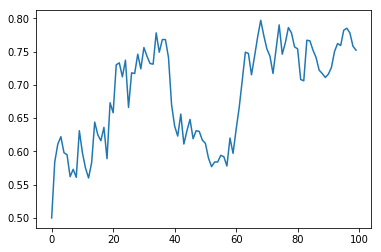

Iteration: 9999

In [7]:
env = tictactoe()

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 10000 #250
save_iterations = 10
discount_rate = 0.95

## bara notað fyrir print og plt
reward_history = []
rew_plt = []
##

from IPython.display import clear_output

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        if iteration%100 == 1:
            clear_output()
            print("\rIteration: {}".format(iteration))
        rnd = True
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            env.reset()
            possible_moves, possible_boards = env.legal_moves(1)
            for step in range(n_max_steps):
                #sess.run([action, gradients]) var að skila vitlausu miðað við action.eval
                #action_val, gradients_val = sess.run([action, gradients], feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)})
                action_val = action.eval(feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)})
                gradients_val = sess.run(gradients, feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)})
                obs, reward, done = env.step(possible_moves[int(action_val)])
                if not done:
                    obs, reward, done = env.make_move()
                    reward = -reward
                    possible_moves, possible_boards = env.legal_moves(1)
                if rnd and iteration%100 == 1:
                    env.render()
                    if done:
                        print('Reward: ',reward)
                        rew_plt.append(np.mean(np.equal(reward_history,1)))
                        reward_history = []
                        plt.plot(rew_plt)
                        plt.show()
                        rnd = False
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    reward_history.append(reward)
                    env.reset()
                    break
            summary = sess.run(merged, feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)})
            file_writer.add_summary(summary, iteration)        
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
#        if iteration % save_iterations == 0:
#            saver.save(sess, "./saver/my_policy_net_pg.ckpt")
    saver.save(sess, "./saver/my_policy_net_pg.ckpt")

In [8]:
# self play 1 game
def render_policy_net(model_path, action, X, games = 1):
    env = tictactoe()
    obs = env.reset()
    possible_moves, possible_boards = env.legal_moves(1)
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            action_val = action.eval(feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)})
            print(outputs.eval(feed_dict={X: np.array(possible_boards).reshape(-1, n_inputs)}))
            obs, reward, done = env.step(possible_moves[int(action_val)])
            env.render()
            env.swap_player()
            possible_moves, possible_boards = env.legal_moves(1)
            if done:
                break


In [9]:
render_policy_net("./saver/my_policy_net_pg.ckpt", action, X)

INFO:tensorflow:Restoring parameters from ./saver/my_policy_net_pg.ckpt
[[9.2862729e-14 4.0640330e-08 6.3956811e-16 7.1963155e-13 9.9993348e-01
  6.6513749e-05 5.8604324e-18 6.4209532e-10 1.2952379e-18]]
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
[[1.8641113e-05 6.2712845e-03 3.2822929e-05 6.3076359e-04 9.9079812e-01
  2.4393869e-06 2.2458322e-03 4.7407369e-08]]
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   |   | 
-------------
[[2.6825223e-06 9.7500110e-01 9.9633191e-10 1.4340273e-05 4.7409581e-12
  2.4981957e-02 6.0811625e-12]]
-------------
|   | x |   | 
-------------
|   | x | o | 
-------------
|   |   |   | 
-------------
[[3.3555385e-03 4.2447238e-03 9.4133489e-02 4.0556680e-04 8.9784741e-01
  1.3317452e-05]]
-------------
|   | o |   | 
-------------
|   | o | x | 
-------------
|   | x |   | 
-------------
[[1.3614047e-01 4.9249309e-05 8.6380935e-01 2.1230561e-07 6.9009235e-07]]
------

In [10]:
feed_dict

{<tf.Tensor 'Placeholder_1:0' shape=(9, 18) dtype=float32>: array([[ 1.95179437e-03,  1.35096321e-02, -1.26242172e-02,
          2.75057517e-02, -9.55605647e-04,  7.00979540e-03,
         -3.27058136e-04,  1.66767053e-02, -1.13986571e-04,
         -2.78616813e-03,  2.05537770e-02,  7.95868319e-03,
         -1.20186328e-03,  7.11183529e-03,  1.25907958e-02,
          1.46168275e-02, -2.66696187e-03,  1.74144823e-02],
        [ 2.66593276e-03,  1.83441453e-02,  7.92263728e-03,
          3.73488776e-02, -4.24101803e-04,  9.51831695e-03,
         -5.91583885e-05,  2.27183998e-02, -1.24055194e-04,
         -7.87587604e-04,  2.79090796e-02,  1.08067496e-02,
         -1.09156920e-03,  9.90561396e-03,  1.70964990e-02,
          1.98478289e-02, -6.15434139e-04,  2.36463733e-02],
        [ 1.43032612e-05,  9.86611412e-05,  1.04986243e-02,
          2.00876864e-04,  5.02739102e-04,  5.11931066e-05,
         -3.35425939e-05,  1.22031954e-04, -9.09235896e-05,
          8.12431041e-04,  1.50104403e-